# Earth-Mars transfer window design using Porkchop Plots

Copyright (c) 2010-2024, Delft University of Technology
All rigths reserved
This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.

## Objectives

This example demonstrates the usage of the tudatpy `porkchop` module to determine an optimal launch window (departure and arrival date) for a **low-thrust** Earth-Mars transfer mission.
By default, the porkchop module uses a Lambert arc to compute the $\Delta V$ required to depart from the departure body (Earth in this case) and be captured by the target body (in this case Mars).
Users can provide a custom function to calculate the $\Delta V$ required for any given transfer. This can be done by supplying a `callable` (a function) to the `porkchop` function via the argument

    function_to_calculate_delta_v

In this example, this option will be used to choose (make a preliminary choice, that is) the optimal departure and arrival date of a low-thrust transfer from the Earth to Mars.

## Import statements

The required import statements are made here, starting with standard imports (`os`, `pickle` from the Python Standard Library), followed by tudatpy imports.

In [1]:
# General imports
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Tudatpy imports
import tudatpy
from tudatpy import constants
from tudatpy import dynamics
from tudatpy.interface import spice
from tudatpy.astro.time_representation import DateTime
from tudatpy.trajectory_design import shape_based_thrust
from tudatpy.trajectory_design import transfer_trajectory
from tudatpy.dynamics import environment_setup
from tudatpy.dynamics import propagation_setup, simulator
from tudatpy.trajectory_design.porkchop import porkchop, plot_porkchop

# Tudatpy data processing utilities
from tudatpy.dynamics.propagation import create_dependent_variable_dictionary
from tudatpy.util import result2array

## Environment setup

The simulation environment is set up here: the standard Spice kernels are loaded, the origin of the global frame is defined, and all necessary bodies are created. 


In [2]:

# Load spice kernels
spice.load_standard_kernels( )

# Define global frame orientation
global_frame_orientation = 'ECLIPJ2000'

# Create bodies
bodies_to_create = ['Sun', 'Venus', 'Earth', 'Moon', 'Mars', 'Jupiter', 'Saturn']
global_frame_origin = 'Sun'
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create vehicle object and add it to the existing system of bodies
vehicle_mass = 4.0E3
specific_impulse = 3000.0
body_settings.add_empty_settings("Vehicle")

body_settings.get("Vehicle").constant_mass = vehicle_mass

# Create rotation model settings
rotation_model_settings = environment_setup.rotation_model.custom_inertial_direction_based(
        lambda time : np.array([1,0,0] ), global_frame_orientation, 'VehicleFixed' )
body_settings.get("Vehicle").rotation_model_settings = rotation_model_settings

# Create bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Create vehicle thrust settings        
thrust_magnitude_settings = (
propagation_setup.thrust.custom_thrust_magnitude_fixed_isp( lambda time : 0.0, specific_impulse ) )
environment_setup.add_engine_model(
    'Vehicle', 'LowThrustEngine', thrust_magnitude_settings, bodies )

## Shape-based low-thrust trajectory optimization

Define the necessary parameters of the low-thrust trajectory:

- Number of revolutions around the Sun
- Free parameters for radial shaping functions
- Free parameters for normal shaping functions
- Free parameters for axial shaping functions


In [3]:
number_of_revolutions = 2

radial_velocity_shaping_free_coefficients = [
    2471.19649906354,
    4207.587982407276
]
normal_velocity_shaping_free_coefficients = [
    -5594.040587888714,
    8748.139268525232,
]
axial_velocity_shaping_free_coefficients = [
    -3449.838496679572,
    0.0
]

### Velocity shaping functions

Define a factory function to obtain the radial velocity shaping functions


In [4]:

def get_radial_velocity_shaping_functions(trajectory_parameters: list,
                                          frequency: float,
                                          scale_factor: float,
                                          time_of_flight: float,
                                          number_of_revolutions: int) -> tuple:
    """
    Retrieves the radial velocity shaping functions (lowest and highest order in Gondelach and Noomen, 2015) and returns
    them together with the free coefficients.

    Parameters
    ----------
    trajectory_parameters : list
        List of trajectory parameters to optimize.
    frequency: float
        Frequency of the highest-order methods.
    scale_factor: float
        Scale factor of the highest-order methods.
    time_of_flight: float
        Time of flight of the trajectory.
    number_of_revolutions: int
        Number of revolutions around the Sun (currently unused).

    Returns
    -------
    tuple
        A tuple composed by two lists: the radial velocity shaping functions and their free coefficients.
    """
    # Retrieve default methods (lowest-order in Gondelach and Noomen, 2015)
    radial_velocity_shaping_functions = shape_based_thrust.recommended_radial_hodograph_functions(time_of_flight)
    # Add degrees of freedom (highest-order in Gondelach and Noomen, 2015)
    radial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    radial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    # Set free parameters
    free_coefficients = trajectory_parameters[3:5]
    return (radial_velocity_shaping_functions,
            free_coefficients)

Define a factory function to obtain the normal velocity shaping functions

In [5]:

def get_normal_velocity_shaping_functions(trajectory_parameters: list,
                                          frequency: float,
                                          scale_factor: float,
                                          time_of_flight: float,
                                          number_of_revolutions: int) -> tuple:
    """
    Retrieves the normal velocity shaping functions (lowest and highest order in Gondelach and Noomen, 2015) and returns
    them together with the free coefficients.

    Parameters
    ----------
    trajectory_parameters : list
        List of trajectory parameters to optimize.
    frequency: float
        Frequency of the highest-order methods.
    scale_factor: float
        Scale factor of the highest-order methods.
    time_of_flight: float
        Time of flight of the trajectory.
    number_of_revolutions: int
        Number of revolutions around the Sun (currently unused).

    Returns
    -------
    tuple
        A tuple composed by two lists: the normal velocity shaping functions and their free coefficients.
    """
    # Retrieve default methods (lowest-order in Gondelach and Noomen, 2015)
    normal_velocity_shaping_functions = shape_based_thrust.recommended_normal_hodograph_functions(time_of_flight)
    # Add degrees of freedom (highest-order in Gondelach and Noomen, 2015)
    normal_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    normal_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
        exponent=1.0,
        frequency=0.5 * frequency,
        scale_factor=scale_factor))
    # Set free parameters
    free_coefficients = trajectory_parameters[5:7]
    return (normal_velocity_shaping_functions,
            free_coefficients)

Define a factory function to obtain the axial velocity shaping functions

In [6]:
def get_axial_velocity_shaping_functions(trajectory_parameters: list,
                                         frequency: float,
                                         scale_factor: float,
                                         time_of_flight: float,
                                         number_of_revolutions: int) -> tuple:
    """
    Retrieves the axial velocity shaping functions (lowest and highest order in Gondelach and Noomen, 2015) and returns
    them together with the free coefficients.

    Parameters
    ----------
    trajectory_parameters : list[ float ]
        List of trajectory parameters to optimize.
    frequency: float
        Frequency of the highest-order methods.
    scale_factor: float
        Scale factor of the highest-order methods.
    time_of_flight: float
        Time of flight of the trajectory.
    number_of_revolutions: int
        Number of revolutions around the Sun.

    Returns
    -------
    tuple
        A tuple composed by two lists: the axial velocity shaping functions and their free coefficients.
    """
    # Retrieve default methods (lowest-order in Gondelach and Noomen, 2015)
    axial_velocity_shaping_functions = shape_based_thrust.recommended_axial_hodograph_functions(
        time_of_flight,
        number_of_revolutions)
    # Add degrees of freedom (highest-order in Gondelach and Noomen, 2015)
    exponent = 4.0
    axial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
        exponent=exponent,
        frequency=(number_of_revolutions + 0.5) * frequency,
        scale_factor=scale_factor ** exponent))
    axial_velocity_shaping_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
        exponent=exponent,
        frequency=(number_of_revolutions + 0.5) * frequency,
        scale_factor=scale_factor ** exponent))
    # Set free parameters
    free_coefficients = trajectory_parameters[7:9]
    return (axial_velocity_shaping_functions,
            free_coefficients)

### Low-thrust Trajectory Optimization solution

Define a function to obtain the LTTO solution

In [7]:

def create_hodographic_trajectory(
        trajectory_parameters: list,
        bodies: tudatpy.dynamics.environment.SystemOfBodies,
        departure_body: str,
        target_body: str,
        central_body: str) \
        -> tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory:
    """
    It creates and returns the hodographic shaping object, based on the trajectory parameters.

    Parameters
    ----------
    trajectory_parameters : list
        List of trajectory parameters to be optimized.
    bodies : tudatpy.dynamics.environment.SystemOfBodies
        System of bodies present in the simulation.

    Returns
    -------
    hodographic_shaping_object : tudatpy.trajectory_design.shape_based_thrust.HodographicShaping
        Hodographic shaping object.
    """

    # Time settings
    initial_time = trajectory_parameters[0] * constants.JULIAN_DAY
    time_of_flight = trajectory_parameters[1] * constants.JULIAN_DAY
    final_time = initial_time + time_of_flight
    
    # Number of revolutions
    number_of_revolutions = int(trajectory_parameters[2])
    
    # Compute relevant frequency and scale factor for shaping functions
    frequency = 2.0 * np.pi / time_of_flight
    scale_factor = 1.0 / time_of_flight
    
    # Retrieve shaping functions and free parameters
    radial_velocity_shaping_functions, radial_free_coefficients = get_radial_velocity_shaping_functions(
        trajectory_parameters,
        frequency,
        scale_factor,
        time_of_flight,
        number_of_revolutions)
    normal_velocity_shaping_functions, normal_free_coefficients = get_normal_velocity_shaping_functions(
        trajectory_parameters,
        frequency,
        scale_factor,
        time_of_flight,
        number_of_revolutions)
    axial_velocity_shaping_functions, axial_free_coefficients = get_axial_velocity_shaping_functions(
        trajectory_parameters,
        frequency,
        scale_factor,
        time_of_flight,
        number_of_revolutions)

    # Create settings for transfer trajectory (zero excess velocity on departure and arrival)
    hodographic_leg_settings = transfer_trajectory.hodographic_shaping_leg(
        radial_velocity_shaping_functions,
        normal_velocity_shaping_functions,
        axial_velocity_shaping_functions )
    node_settings = list()
    node_settings.append( transfer_trajectory.departure_node( 1.0E8, 0.0 ) )
    node_settings.append( transfer_trajectory.capture_node( 1.0E8, 0.0 ) )

    # Create and return transfer trajectory
    trajectory_object = transfer_trajectory.create_transfer_trajectory(
        bodies, [hodographic_leg_settings], node_settings, [departure_body, target_body], central_body )

    # Extract node times
    node_times = list( )
    node_times.append( initial_time )
    node_times.append( final_time )

    #transfer_trajectory.print_parameter_definitions( [hodographic_leg_settings], node_settings )
    hodograph_free_parameters = trajectory_parameters[2:9]

    # Depart and arrive with 0 excess velocity
    node_parameters = list()
    node_parameters.append( np.zeros([3,1]))
    node_parameters.append( np.zeros([3,1]))

    # Update trajectory to given times, node settings, and hodograph parameters
    trajectory_object.evaluate( node_times, [hodograph_free_parameters], node_parameters )

    return trajectory_object

Create function to obtain transfer $\Delta V$

In [8]:

def hodographic_low_thrust_trajectory_delta_v(
        bodies: tudatpy.dynamics.environment.SystemOfBodies,
        departure_body: str,
        target_body: str,
        departure_epoch: float,
        arrival_epoch: float,
        central_body: str = 'Sun') \
    -> list[tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory, float]:
    """
    Function to calculate the required ΔV of an Earth-Mars transfer

    Parameters
    ----------
    bodies : tudatpy.dynamics.environment.SystemOfBodies
        The system of bodies containing the celestial bodies involved in the transfer.
    departure_body : str
        The name of the departure celestial body.
    target_body : str
        The name of the target celestial body.
    departure_epoch : float
        The departure epoch in seconds since J2000.
    arrival_epoch : float
        The arrival epoch in seconds since J2000.
    central_body : str, optional
        The name of the central celestial body (default is 'Sun').

    Returns
    -------
    [tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory, float]
        A tuple containing the transfer trajectory object and the required ΔV.
    """
    
    # The entries of the vector 'trajectory_parameters' contains the following:
    # * Entry 0: Departure time (from Earth's center-of-mass) in Julian days since J2000
    # * Entry 1: Time-of-flight from Earth's center-of-mass to Mars' center-of-mass, in Julian days
    # * Entry 2: Number of revolutions around the Sun
    # * Entry 3,4: Free parameters for radial shaping functions
    # * Entry 5,6: Free parameters for normal shaping functions
    # * Entry 7,8: Free parameters for axial shaping functions
    
    trajectory_parameters = [
        departure_epoch / constants.JULIAN_DAY,
        (arrival_epoch - departure_epoch) / constants.JULIAN_DAY,
        number_of_revolutions,
        *radial_velocity_shaping_free_coefficients,
        *normal_velocity_shaping_free_coefficients,
        *axial_velocity_shaping_free_coefficients
    ]

    hodographic_shaping_object = create_hodographic_trajectory(
        trajectory_parameters,
        bodies,
        departure_body,
        target_body,
        central_body)

    # Retrieve delta V
    ΔV = hodographic_shaping_object.delta_v

    return ΔV


## Porkchop Plots

The departure and target bodies and the time window for the transfer are then defined using tudatpy `astro.time_representation.DateTime` objects.

In [9]:
departure_body = 'Earth'
target_body = 'Mars'

earliest_departure_time = DateTime(2016,  9,   1)
latest_departure_time   = DateTime(2017,  7,   1)

earliest_arrival_time   = DateTime(2019, 11,   1)
latest_arrival_time     = DateTime(2021,  9,   1)

To ensure the porkchop plot is rendered with good resolution, the time resolution of the plot is defined as 0.5% of the smallest time window (either the arrival or the departure window):

In [10]:
time_window_percentage = 0.5
time_resolution = time_resolution = min(
        latest_departure_time.epoch() - earliest_departure_time.epoch(),
        latest_arrival_time.epoch()   - earliest_arrival_time.epoch()
) / constants.JULIAN_DAY * time_window_percentage / 100

Generating a high-resolution plot may be time-consuming: reusing saved data might be desirable; we proceed to ask the user whether to reuse saved data or generate the plot from scratch.

In [11]:
# File
data_file = 'porkchop.pkl'

# Whether to recalculate the porkchop plot or use saved data
RECALCULATE_delta_v = True#input(
#    '\n    Recalculate ΔV for porkchop plot? [y/N] '
#).strip().lower() == 'y'
#print()

Lastly, we call the `porkchop` function, which will calculate the $\Delta V$ required at each departure-arrival coordinate and display the plot, giving us
 
- The optimal departure-arrival date combination
- The constant time-of-flight isochrones
- And more

  0%|                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                                      | 1/200 [00:02<07:31,  2.27s/it]

  1%|█▋                                                                                                                                                                     | 2/200 [00:04<07:30,  2.27s/it]

  2%|██▌                                                                                                                                                                    | 3/200 [00:06<07:28,  2.28s/it]

  2%|███▎                                                                                                                                                                   | 4/200 [00:09<07:25,  2.27s/it]

  2%|████▏                                                                                                                                                                  | 5/200 [00:11<07:22,  2.27s/it]

  3%|█████                                                                                                                                                                  | 6/200 [00:13<07:20,  2.27s/it]

  4%|█████▊                                                                                                                                                                 | 7/200 [00:15<07:18,  2.27s/it]

  4%|██████▋                                                                                                                                                                | 8/200 [00:18<07:16,  2.27s/it]

  4%|███████▌                                                                                                                                                               | 9/200 [00:20<07:13,  2.27s/it]

  5%|████████▎                                                                                                                                                             | 10/200 [00:22<07:12,  2.28s/it]

  6%|█████████▏                                                                                                                                                            | 11/200 [00:24<07:09,  2.27s/it]

  6%|█████████▉                                                                                                                                                            | 12/200 [00:27<07:07,  2.27s/it]

  6%|██████████▊                                                                                                                                                           | 13/200 [00:29<07:04,  2.27s/it]

  7%|███████████▌                                                                                                                                                          | 14/200 [00:31<07:02,  2.27s/it]

  8%|████████████▍                                                                                                                                                         | 15/200 [00:34<06:59,  2.27s/it]

  8%|█████████████▎                                                                                                                                                        | 16/200 [00:36<06:57,  2.27s/it]

  8%|██████████████                                                                                                                                                        | 17/200 [00:38<06:55,  2.27s/it]

  9%|██████████████▉                                                                                                                                                       | 18/200 [00:40<06:52,  2.27s/it]

 10%|███████████████▊                                                                                                                                                      | 19/200 [00:43<06:50,  2.27s/it]

 10%|████████████████▌                                                                                                                                                     | 20/200 [00:45<06:48,  2.27s/it]

 10%|█████████████████▍                                                                                                                                                    | 21/200 [00:47<06:46,  2.27s/it]

 11%|██████████████████▎                                                                                                                                                   | 22/200 [00:49<06:44,  2.27s/it]

 12%|███████████████████                                                                                                                                                   | 23/200 [00:52<06:42,  2.27s/it]

 12%|███████████████████▉                                                                                                                                                  | 24/200 [00:54<06:39,  2.27s/it]

 12%|████████████████████▊                                                                                                                                                 | 25/200 [00:56<06:37,  2.27s/it]

 13%|█████████████████████▌                                                                                                                                                | 26/200 [00:59<06:35,  2.27s/it]

 14%|██████████████████████▍                                                                                                                                               | 27/200 [01:01<06:32,  2.27s/it]

 14%|███████████████████████▏                                                                                                                                              | 28/200 [01:03<06:30,  2.27s/it]

 14%|████████████████████████                                                                                                                                              | 29/200 [01:05<06:28,  2.27s/it]

 15%|████████████████████████▉                                                                                                                                             | 30/200 [01:08<06:26,  2.27s/it]

 16%|█████████████████████████▋                                                                                                                                            | 31/200 [01:10<06:24,  2.27s/it]

 16%|██████████████████████████▌                                                                                                                                           | 32/200 [01:12<06:21,  2.27s/it]

 16%|███████████████████████████▍                                                                                                                                          | 33/200 [01:14<06:19,  2.27s/it]

 17%|████████████████████████████▏                                                                                                                                         | 34/200 [01:17<06:16,  2.27s/it]

 18%|█████████████████████████████                                                                                                                                         | 35/200 [01:19<06:15,  2.27s/it]

 18%|█████████████████████████████▉                                                                                                                                        | 36/200 [01:21<06:12,  2.27s/it]

 18%|██████████████████████████████▋                                                                                                                                       | 37/200 [01:24<06:10,  2.27s/it]

 19%|███████████████████████████████▌                                                                                                                                      | 38/200 [01:26<06:08,  2.28s/it]

 20%|████████████████████████████████▎                                                                                                                                     | 39/200 [01:28<06:06,  2.27s/it]

 20%|█████████████████████████████████▏                                                                                                                                    | 40/200 [01:30<06:04,  2.28s/it]

 20%|██████████████████████████████████                                                                                                                                    | 41/200 [01:33<06:01,  2.27s/it]

 21%|██████████████████████████████████▊                                                                                                                                   | 42/200 [01:35<05:59,  2.27s/it]

 22%|███████████████████████████████████▋                                                                                                                                  | 43/200 [01:37<05:56,  2.27s/it]

 22%|████████████████████████████████████▌                                                                                                                                 | 44/200 [01:39<05:54,  2.27s/it]

 22%|█████████████████████████████████████▎                                                                                                                                | 45/200 [01:42<05:52,  2.27s/it]

 23%|██████████████████████████████████████▏                                                                                                                               | 46/200 [01:44<05:50,  2.27s/it]

 24%|███████████████████████████████████████                                                                                                                               | 47/200 [01:46<05:47,  2.27s/it]

 24%|███████████████████████████████████████▊                                                                                                                              | 48/200 [01:49<05:45,  2.27s/it]

 24%|████████████████████████████████████████▋                                                                                                                             | 49/200 [01:51<05:43,  2.28s/it]

 25%|█████████████████████████████████████████▌                                                                                                                            | 50/200 [01:53<05:41,  2.28s/it]

 26%|██████████████████████████████████████████▎                                                                                                                           | 51/200 [01:55<05:39,  2.28s/it]

 26%|███████████████████████████████████████████▏                                                                                                                          | 52/200 [01:58<05:37,  2.28s/it]

 26%|███████████████████████████████████████████▉                                                                                                                          | 53/200 [02:00<05:34,  2.28s/it]

 27%|████████████████████████████████████████████▊                                                                                                                         | 54/200 [02:02<05:32,  2.27s/it]

 28%|█████████████████████████████████████████████▋                                                                                                                        | 55/200 [02:04<05:29,  2.27s/it]

 28%|██████████████████████████████████████████████▍                                                                                                                       | 56/200 [02:07<05:27,  2.27s/it]

 28%|███████████████████████████████████████████████▎                                                                                                                      | 57/200 [02:09<05:25,  2.27s/it]

 29%|████████████████████████████████████████████████▏                                                                                                                     | 58/200 [02:11<05:22,  2.27s/it]

 30%|████████████████████████████████████████████████▉                                                                                                                     | 59/200 [02:14<05:20,  2.27s/it]

 30%|█████████████████████████████████████████████████▊                                                                                                                    | 60/200 [02:16<05:17,  2.27s/it]

 30%|██████████████████████████████████████████████████▋                                                                                                                   | 61/200 [02:18<05:15,  2.27s/it]

 31%|███████████████████████████████████████████████████▍                                                                                                                  | 62/200 [02:20<05:13,  2.27s/it]

 32%|████████████████████████████████████████████████████▎                                                                                                                 | 63/200 [02:23<05:10,  2.27s/it]

 32%|█████████████████████████████████████████████████████                                                                                                                 | 64/200 [02:25<05:08,  2.27s/it]

 32%|█████████████████████████████████████████████████████▉                                                                                                                | 65/200 [02:27<05:06,  2.27s/it]

 33%|██████████████████████████████████████████████████████▊                                                                                                               | 66/200 [02:29<05:04,  2.27s/it]

 34%|███████████████████████████████████████████████████████▌                                                                                                              | 67/200 [02:32<05:02,  2.27s/it]

 34%|████████████████████████████████████████████████████████▍                                                                                                             | 68/200 [02:34<05:00,  2.27s/it]

 34%|█████████████████████████████████████████████████████████▎                                                                                                            | 69/200 [02:36<04:57,  2.27s/it]

 35%|██████████████████████████████████████████████████████████                                                                                                            | 70/200 [02:39<04:55,  2.27s/it]

 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 71/200 [02:41<04:53,  2.27s/it]

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 72/200 [02:43<04:51,  2.27s/it]

 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 73/200 [02:45<04:48,  2.27s/it]

 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 74/200 [02:48<04:46,  2.27s/it]

 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 75/200 [02:50<04:44,  2.27s/it]

 38%|███████████████████████████████████████████████████████████████                                                                                                       | 76/200 [02:52<04:44,  2.29s/it]

 38%|███████████████████████████████████████████████████████████████▉                                                                                                      | 77/200 [02:55<04:41,  2.29s/it]

 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 78/200 [02:57<04:38,  2.28s/it]

 40%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 79/200 [02:59<04:35,  2.28s/it]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 80/200 [03:01<04:33,  2.28s/it]

 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 81/200 [03:04<04:30,  2.28s/it]

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 82/200 [03:06<04:28,  2.28s/it]

 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 83/200 [03:08<04:26,  2.27s/it]

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 84/200 [03:10<04:24,  2.28s/it]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 85/200 [03:13<04:22,  2.28s/it]

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 86/200 [03:15<04:20,  2.28s/it]

 44%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 87/200 [03:17<04:18,  2.28s/it]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 88/200 [03:20<04:15,  2.28s/it]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 89/200 [03:22<04:13,  2.28s/it]

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 90/200 [03:24<04:10,  2.28s/it]

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 91/200 [03:26<04:07,  2.27s/it]

 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 92/200 [03:29<04:05,  2.27s/it]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 93/200 [03:31<04:02,  2.27s/it]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 94/200 [03:33<04:00,  2.27s/it]

 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 95/200 [03:35<03:36,  2.07s/it]

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 96/200 [03:36<03:13,  1.86s/it]

 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 97/200 [03:38<02:56,  1.72s/it]

 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 98/200 [03:39<02:46,  1.63s/it]

 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 99/200 [03:40<02:37,  1.56s/it]

 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 100/200 [03:42<02:33,  1.54s/it]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 101/200 [03:43<02:29,  1.51s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 102/200 [03:45<02:25,  1.49s/it]

 52%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 103/200 [03:46<02:24,  1.49s/it]

 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 104/200 [03:48<02:21,  1.47s/it]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 105/200 [03:49<02:19,  1.46s/it]

 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 106/200 [03:51<02:16,  1.45s/it]

 54%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 107/200 [03:52<02:14,  1.45s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                            | 108/200 [03:53<02:13,  1.45s/it]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 109/200 [03:55<02:12,  1.46s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 110/200 [03:56<02:13,  1.48s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 111/200 [03:58<02:12,  1.49s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 112/200 [03:59<02:10,  1.48s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 113/200 [04:01<02:09,  1.49s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 114/200 [04:02<02:07,  1.48s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 115/200 [04:04<02:06,  1.49s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 116/200 [04:05<02:04,  1.48s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 117/200 [04:07<02:05,  1.51s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 118/200 [04:08<02:03,  1.51s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 119/200 [04:10<02:03,  1.52s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 120/200 [04:12<02:01,  1.51s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 121/200 [04:13<02:01,  1.53s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 122/200 [04:15<01:59,  1.53s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 123/200 [04:16<01:57,  1.53s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 124/200 [04:18<02:01,  1.60s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 125/200 [04:19<01:59,  1.60s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 126/200 [04:21<01:59,  1.61s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 127/200 [04:23<01:57,  1.61s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 128/200 [04:24<01:53,  1.58s/it]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 129/200 [04:26<01:51,  1.57s/it]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 130/200 [04:27<01:49,  1.56s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 131/200 [04:29<01:47,  1.55s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 132/200 [04:30<01:46,  1.57s/it]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 133/200 [04:32<01:43,  1.54s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 134/200 [04:34<01:42,  1.56s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 135/200 [04:35<01:41,  1.56s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 136/200 [04:37<01:39,  1.56s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 137/200 [04:38<01:36,  1.54s/it]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 138/200 [04:40<01:34,  1.53s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 139/200 [04:41<01:33,  1.54s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 140/200 [04:43<01:31,  1.53s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 141/200 [04:44<01:30,  1.54s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 142/200 [04:46<01:30,  1.56s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 143/200 [04:47<01:28,  1.56s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 144/200 [04:49<01:27,  1.56s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 145/200 [04:51<01:26,  1.57s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 146/200 [04:52<01:23,  1.55s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 147/200 [04:54<01:21,  1.54s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 148/200 [04:55<01:20,  1.54s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 149/200 [04:57<01:19,  1.55s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 150/200 [04:58<01:17,  1.54s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 151/200 [05:00<01:15,  1.54s/it]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 152/200 [05:01<01:14,  1.55s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 153/200 [05:03<01:12,  1.53s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 154/200 [05:04<01:10,  1.54s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 155/200 [05:06<01:08,  1.53s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 156/200 [05:07<01:06,  1.52s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 157/200 [05:09<01:05,  1.53s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 158/200 [05:11<01:04,  1.54s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 159/200 [05:12<01:03,  1.55s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 160/200 [05:14<01:01,  1.55s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 161/200 [05:15<01:00,  1.55s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 162/200 [05:17<00:58,  1.54s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 163/200 [05:18<00:57,  1.55s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 164/200 [05:20<00:55,  1.55s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 165/200 [05:21<00:54,  1.55s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 166/200 [05:23<00:52,  1.53s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 167/200 [05:25<00:51,  1.56s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 168/200 [05:26<00:49,  1.55s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 169/200 [05:28<00:48,  1.55s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 170/200 [05:29<00:46,  1.55s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 171/200 [05:31<00:45,  1.55s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 172/200 [05:32<00:44,  1.57s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 173/200 [05:34<00:41,  1.55s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 174/200 [05:35<00:40,  1.55s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 175/200 [05:37<00:38,  1.55s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 176/200 [05:38<00:37,  1.55s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 177/200 [05:40<00:35,  1.54s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 178/200 [05:42<00:34,  1.55s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 179/200 [05:43<00:32,  1.55s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 180/200 [05:45<00:31,  1.56s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 181/200 [05:46<00:29,  1.55s/it]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 182/200 [05:48<00:27,  1.55s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 183/200 [05:49<00:26,  1.56s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 184/200 [05:51<00:25,  1.57s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 185/200 [05:52<00:23,  1.56s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 186/200 [05:54<00:21,  1.57s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 187/200 [05:56<00:20,  1.57s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 188/200 [05:57<00:18,  1.57s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 189/200 [05:59<00:17,  1.58s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 190/200 [06:00<00:15,  1.59s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 191/200 [06:02<00:14,  1.58s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 192/200 [06:04<00:12,  1.57s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 193/200 [06:05<00:10,  1.57s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 194/200 [06:07<00:09,  1.57s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 195/200 [06:08<00:07,  1.56s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 196/200 [06:10<00:06,  1.56s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 197/200 [06:12<00:04,  1.65s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 198/200 [06:13<00:03,  1.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [06:15<00:01,  1.66s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:17<00:00,  1.64s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:17<00:00,  1.89s/it]


/home/dominic/miniconda3/envs/tudat-clean-post-epsc/lib/python3.11/site-packages/tudatpy/trajectory_design/porkchop/_plot_porkchop.py:178: RuntimeWarning: divide by zero encountered in log10
  np.log10(field_within_range.min()),
/home/dominic/miniconda3/envs/tudat-clean-post-epsc/lib/python3.11/site-packages/tudatpy/trajectory_design/porkchop/_plot_porkchop.py:179: RuntimeWarning: divide by zero encountered in log10
  np.log10(field_within_range.max()),
/home/dominic/miniconda3/envs/tudat-clean-post-epsc/lib/python3.11/site-packages/matplotlib/transforms.py:984: UserWarning: Warning: converting a masked element to nan.
  self._points[:, 1] = interval


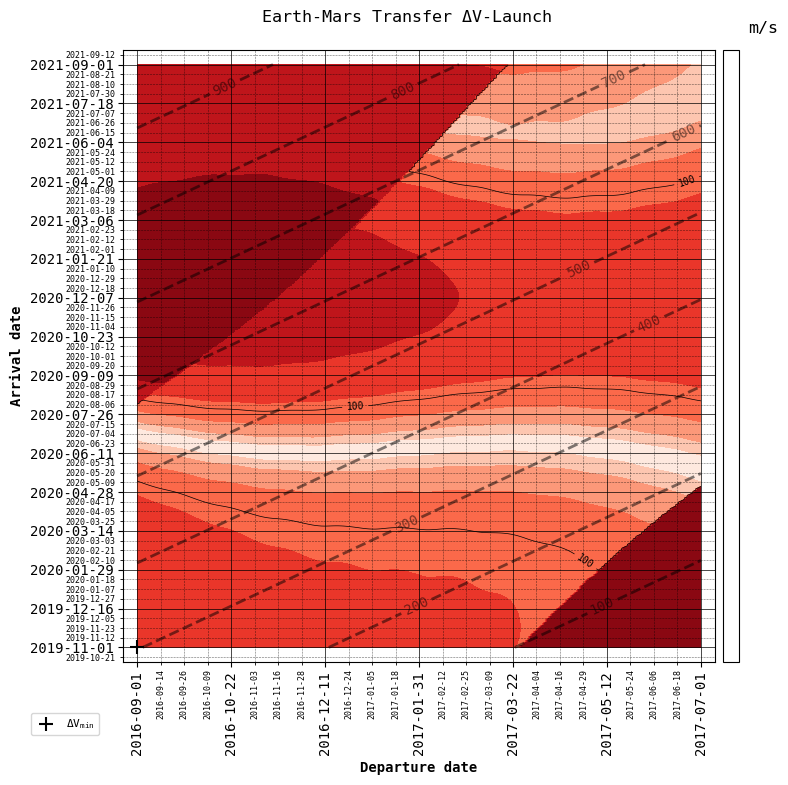

In [12]:

if not os.path.isfile(data_file) or RECALCULATE_delta_v:
    # Regenerate plot
    [departure_epochs, arrival_epochs, ΔV] = porkchop(
        bodies,
        departure_body,
        target_body,
        earliest_departure_time,
        latest_departure_time,
        earliest_arrival_time,
        latest_arrival_time,
        time_resolution,
        function_to_calculate_delta_v=hodographic_low_thrust_trajectory_delta_v
    )
    # Save data
    pickle.dump(
        [departure_epochs, arrival_epochs, ΔV],
        open(data_file, 'wb')
    )
else:
    # Read saved data
    [departure_epochs, arrival_epochs, ΔV] = pickle.load(
        open(data_file, 'rb')
    )
    # Plot saved data
    plot_porkchop(
        departure_body   = departure_body,
        target_body      = target_body,
        departure_epochs = departure_epochs, 
        arrival_epochs   = arrival_epochs, 
        delta_v          = ΔV,
        threshold        = 60
    )

### Variations

The Tudat `porkchop` module allows us to

- Save the $\Delta V$ porkchop returned by `porkchop` and plot it again without recalculating with the `plot_porkchop` function
- Plot $\Delta V$ (default) or C3 (specific energy), as well as choose whether to plot departure and arrival $\Delta V$ together as the total $\Delta V$ required for the transfer (default), or separately (in those cases in which the manoeuvre is performed in two burns, one at departure and one at arrival to the target planet).

Let's make use of `plot_porkchop` to see all four combinations!

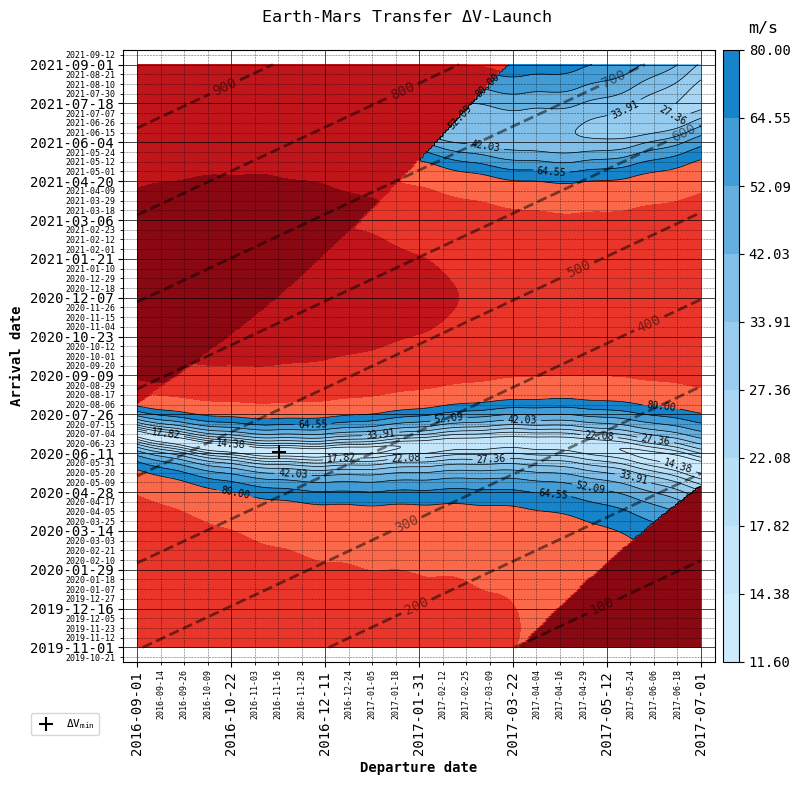

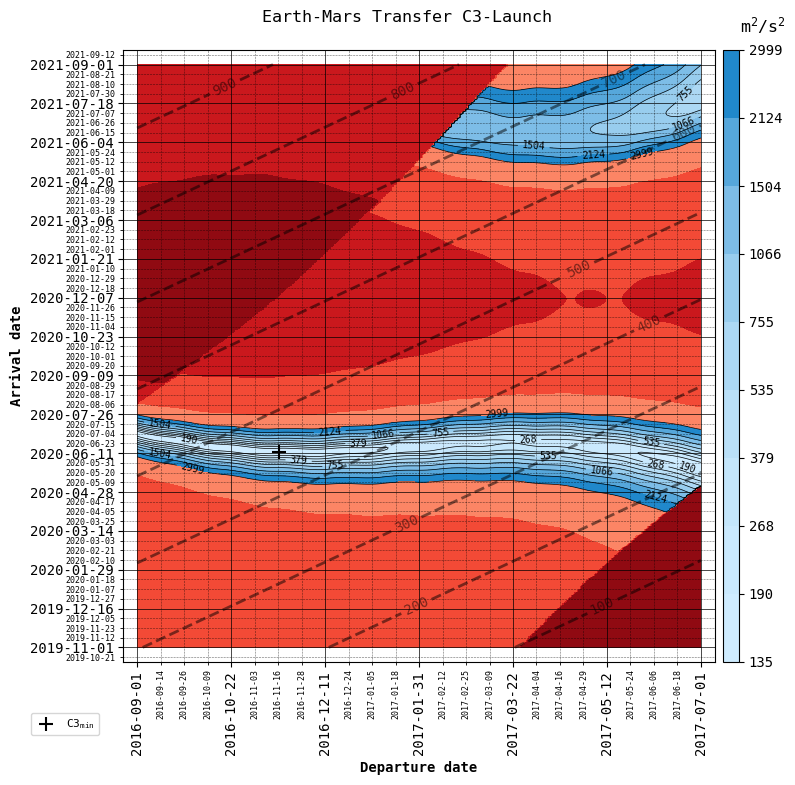

In [13]:
cases = [
    {'C3': False, 'total': True,  'threshold': 80,   'filename': 'figures/Δ_tot.png'},
    {'C3': True,  'total': True,  'threshold': 3000, 'filename': 'figures/C3_tot.png'}
]

for case in cases:
    plot_porkchop(
        departure_body   = departure_body,
        target_body      = target_body,
        departure_epochs = departure_epochs, 
        arrival_epochs   = arrival_epochs, 
        delta_v          = ΔV,
        save             = False,
        **case
    )


# Verification

Interestingly, discontinuities appear in the $\Delta V$/$C_3$ porkchop. To ensure that the porkchop can be trusted -that it is possible to choose a transfer window based on our porkchop-, we will proceed to investigate two transfers:

- The (approximately) minimum $\Delta V$ transfer: `2016-11-16`-`2020-6-11`
- A high $\Delta V$ transfer in the dark red region of the porkchop: `2016-10-22`-`2021-01-21`

## Trajectory visualization

Provided with a transfer window, the following function will obtain the shape-based low thrust trajectory from the Earth to Mars, numerically propagate a trajectory using a low-thrust thrust model for our spacecraft, and plot the: 

- Cartesian coordinates of the spacecraft, as a function of time, both for the analytical and integrated trajectory
- The Cartesian coordinates as a function of time of the Earth and Mars
- The thrust acceleration on the spacecraft as a function of time
- And a 3D plot showing the complete manoeuvre

In [14]:
def inspect_low_thrust_trajectory(
        departure_date: DateTime,
        arrival_date: DateTime
    ):
    """
    This function has the following sections:

    1. Define transfer parameters
    2. Obtain low-thrust shape-based semi-analytical trajectory
    3. Create vehicle thrust settings
    4. Create termination settings
    5. Propagator settings
    6. Integrator settings
    7. Propagate dynamics
    8. Process simulation output
    9. Retrieve ephemeris of astronomical bodies
    10. Plot trajectory 
    """

    ###########################################################################
    # DEFINE TRANSFER PARAMETERS ##############################################
    ###########################################################################

    trajectory_parameters = [
        departure_date.epoch() / constants.JULIAN_DAY,
        (arrival_date.epoch() - departure_date.epoch()) / constants.JULIAN_DAY,
        number_of_revolutions,
        *radial_velocity_shaping_free_coefficients,
        *normal_velocity_shaping_free_coefficients,
        *axial_velocity_shaping_free_coefficients
    ]

    # Fixed parameters
    minimum_mars_distance = 5.0E7
    # Time since 'departure from Earth CoM' at which propagation starts (and similar
    # for arrival time)
    time_buffer = 30.0 * constants.JULIAN_DAY

    # Propagation time settings
    initial_propagation_time = departure_date.epoch() + time_buffer
    final_propagation_time = arrival_date.epoch() - time_buffer

    ###########################################################################
    # OBTAIN LOW-THRUST SHAPE-BASED SEMI-ANALYTICAL TRAJECTORY ################
    ###########################################################################

    # Create problem without propagating
    hodographic_shaping_object = create_hodographic_trajectory(
        trajectory_parameters, 
        bodies,
        'Earth',
        'Mars',
        'Sun'
    )

    # Retrieves analytical results and write them to a file
    analytical_trajectory = lambda n: result2array(hodographic_shaping_object.states_along_trajectory(n))[:, 1:]

    # Report transfer ΔV
    print(f'{hodographic_shaping_object.delta_v/1000:.2f} km/s')

    ###########################################################################
    # CREATE TERMINATION SETTINGS #############################################
    ###########################################################################

    # Time settings
    time_termination_settings = propagation_setup.propagator.time_termination(
        final_propagation_time,
        terminate_exactly_on_final_condition=False)
    # Altitude
    relative_distance_termination_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=propagation_setup.dependent_variable.relative_distance('Vehicle', 'Mars'),
        limit_value=minimum_mars_distance,
        use_as_lower_limit=True,
        terminate_exactly_on_final_condition=False)
    # Define list of termination settings
    termination_settings_list = [time_termination_settings,
                                 relative_distance_termination_settings]
    # Create termination settings object
    termination_settings = propagation_setup.propagator.hybrid_termination(termination_settings_list,
                                                                           fulfill_single_condition=True)
    
    # Retrieve dependent variables to save
    dependent_variables_to_save = [
        propagation_setup.dependent_variable.relative_distance('Vehicle', 'Earth'),
        propagation_setup.dependent_variable.relative_distance('Vehicle', 'Sun'),
        propagation_setup.dependent_variable.relative_distance('Vehicle', 'Mars'),
        propagation_setup.dependent_variable.single_acceleration_norm(
            propagation_setup.acceleration.thrust_acceleration_type,'Vehicle','Vehicle')
    ]

    ###########################################################################
    # PROPAGATOR SETTINGS #####################################################
    ###########################################################################

    current_propagator = propagation_setup.propagator.unified_state_model_quaternions

    # Define propagation settings
        # Define bodies that are propagated and their central bodies of propagation
    bodies_to_propagate = ['Vehicle']
    central_bodies = ['Sun']

    # Update vehicle rotation model and thrust magnitude model
    transfer_trajectory.set_low_thrust_acceleration( hodographic_shaping_object.legs[ 0 ], bodies, 'Vehicle', 'LowThrustEngine' )
    
    # Define accelerations acting on capsule
    acceleration_settings_on_vehicle = {
        'Sun': [propagation_setup.acceleration.point_mass_gravity()],
        'Vehicle': [propagation_setup.acceleration.thrust_from_engine('LowThrustEngine')]
    }

    # Create global accelerations dictionary
    acceleration_settings = {'Vehicle': acceleration_settings_on_vehicle}
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies,
        acceleration_settings,
        bodies_to_propagate,
        central_bodies)

    # Retrieve initial state
    initial_state = hodographic_shaping_object.legs[ 0 ].state_along_trajectory( initial_propagation_time )

    # Create propagation settings for the translational dynamics
    translational_propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        initial_propagation_time,
        None,
        termination_settings,
        current_propagator,
        output_variables=dependent_variables_to_save)

    # Create mass rate model
    mass_rate_settings_on_vehicle = {'Vehicle': [propagation_setup.mass_rate.from_thrust()]}
    mass_rate_models = propagation_setup.create_mass_rate_models(bodies,
                                                                 mass_rate_settings_on_vehicle,
                                                                 acceleration_models)
    # Create mass propagator settings
    mass_propagator_settings = propagation_setup.propagator.mass(bodies_to_propagate,
                                                                 mass_rate_models,
                                                                 np.array([vehicle_mass]),
                                                                 initial_propagation_time,
                                                                 None,
                                                                 termination_settings)

    # Create multi-type propagation settings list
    propagator_settings_list = [translational_propagator_settings,
                                mass_propagator_settings]

    # Create multi-type propagation settings object for translational dynamics and mass
    propagator_settings = propagation_setup.propagator.multitype(propagator_settings_list,
                                                                 None,
                                                                 initial_propagation_time,
                                                                 termination_settings,
                                                                 dependent_variables_to_save)
    
    ###########################################################################
    # INTEGRATOR SETTINGS #####################################################
    ###########################################################################

    # Create integrator settings
    current_tolerance = 10.0 ** (-10.0)
    # Create integrator settings
    integrator = propagation_setup.integrator
    # Define fixed step size
    step_size = constants.JULIAN_DAY
    # Here (epsilon, inf) are set as respectively min and max step sizes
    # also note that the relative and absolute tolerances are the same value
    integrator_settings = integrator.runge_kutta_variable_step_size(
        step_size,
        propagation_setup.integrator.CoefficientSets.rkdp_87,
        step_size,
        step_size,
        current_tolerance,
        current_tolerance)
    propagator_settings.integrator_settings = integrator_settings

    ###########################################################################
    # PROPAGATE DYNAMICS ######################################################
    ###########################################################################
    dynamics_simulator = simulator.create_dynamics_simulator(
        bodies, propagator_settings )

    ###########################################################################
    # PROCESS SIMULATION OUTPUT ###############################################
    ###########################################################################
    # Retrieve propagated state and dependent variables
    state_history = dynamics_simulator.propagation_results.state_history

    # Create dependent variable dictionary
    dv_dict = create_dependent_variable_dictionary(dynamics_simulator)

    # Create state history array
    state_history_array = result2array(state_history)

    # Retrieve propagation buffer time
    buffer = time_buffer / constants.JULIAN_DAY

    # Retrieve time vector
    t = state_history_array[:, 0] / constants.JULIAN_DAY
    t = (t - t[0]) + buffer

    # Retrieve analytical time vector
    t_analytical = np.arange(0, max(t)+buffer+1, step_size/constants.JULIAN_DAY)

    # Retrieve x, y and z position history
    x = state_history_array[:, 1]
    y = state_history_array[:, 2]
    z = state_history_array[:, 3]

    # Retrieve analytical trajectory
    x_analytical = analytical_trajectory(len(t_analytical))[:, 0]
    y_analytical = analytical_trajectory(len(t_analytical))[:, 1]
    z_analytical = analytical_trajectory(len(t_analytical))[:, 2]

    # Retrieve thrust magnitude
    thrust_magnitude = dv_dict.asarray('Single acceleration norm of type thrust , acting on Vehicle')

    ###########################################################################
    # RETRIEVE EPHEMERIS OF ASTRONOMICAL BODIES ###############################
    ###########################################################################

    retrieve_ephemeris = lambda body: np.vstack([spice.get_body_cartesian_state_at_epoch(
        target_body_name=body,
        observer_body_name="SSB",
        reference_frame_name="ECLIPJ2000",
        aberration_corrections="NONE",
        ephemeris_time=epoch_in_days * constants.JULIAN_DAY
    )[:3] for epoch_in_days in np.linspace(trajectory_parameters[0], trajectory_parameters[0] + trajectory_parameters[1], len(t_analytical))])

    # Retrieve trajectory of the Earth
    earth_trajectory = retrieve_ephemeris('Earth')
    earth_x = earth_trajectory[:, 0]
    earth_y = earth_trajectory[:, 1]
    earth_z = earth_trajectory[:, 2]

    # Retrieve trajectory of mars
    mars_trajectory = retrieve_ephemeris('Mars')
    mars_x = mars_trajectory[:, 0]
    mars_y = mars_trajectory[:, 1]
    mars_z = mars_trajectory[:, 2]

    ###########################################################################
    # PLOT TRAJECTORY #########################################################
    ###########################################################################

    # Create figure
    fig = plt.figure(figsize=(15, 7))

    # Create 3 subplots for x, y, z coordinates
    ax1 = plt.subplot2grid((4, 2), (0, 0))
    ax2 = plt.subplot2grid((4, 2), (1, 0), sharex=ax1)
    ax3 = plt.subplot2grid((4, 2), (2, 0), sharex=ax1)
    ax4 = plt.subplot2grid((4, 2), (3, 0), sharex=ax1)

    # Plot analytical and numerical coordinates
    ax1.plot(t_analytical, x_analytical, label='Analytical')
    ax1.plot(t, x, label='Numerical')
    ax1.plot(t_analytical, earth_x, label='Earth', color='#78c4ff', zorder=1, alpha=0.6)
    ax1.plot(t_analytical, mars_x, label='Mars', color='#f04848', zorder=1, alpha=0.6)
    ax1.set_ylabel('X [km]')

    ax2.plot(t_analytical, y_analytical)
    ax2.plot(t, y)
    ax2.plot(t_analytical, earth_y, color='#78c4ff', zorder=1, alpha=0.6)
    ax2.plot(t_analytical, mars_y, color='#f04848', zorder=1, alpha=0.6)
    ax2.set_ylabel('Y [km]')

    ax3.plot(t_analytical, z_analytical)
    ax3.plot(t, z)
    ax3.plot(t_analytical, earth_z, color='#78c4ff', zorder=1, alpha=0.6)
    ax3.plot(t_analytical, mars_z, color='#f04848', zorder=1, alpha=0.6)
    ax3.set_ylabel('Z [km]')

    ax4.plot(t, thrust_magnitude / vehicle_mass, color='green', label='Thrust acceleration')
    ax4.set_ylabel('$||a_T||$ [$m/s^2$]')
    ax4.set_xlabel('Time [days]')

    # Legend
    fig.legend(loc='lower center', ncol=5)

    # Create a 3D subplot for the trajectories
    ax5 = plt.subplot2grid((3, 2), (0, 1), rowspan=3, projection='3d')
    ax5.view_init(elev=32, azim=-66)

    # Plot Earth trajectory
    ax5.plot(earth_x, earth_y, earth_z, color='#78c4ff')
    ax5.scatter(earth_x[0], earth_y[0], earth_z[0], label='Earth, $t_0$', marker='$\Lambda$', s=100, color='#1f9eff')

    # Plot Mars trajectory
    ax5.plot(mars_x, mars_y, mars_z, color='#f04848')
    ax5.scatter(mars_x[-1], mars_y[-1], mars_z[-1], label='Mars, $t_f$', marker='$\Gamma$', s=100, color='#c93232')

    # Plot the 3D trajectories
    ax5.plot(x_analytical, y_analytical, z_analytical)
    ax5.plot(x, y, z)

    # Set labels
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_zlabel('Z')

    # Show the legend
    ax5.legend()

    # Grid
    for ax in [ax1, ax2, ax3, ax4]: ax.grid(
        True,
        which='major',
        color='grey',
        linestyle='--'
    )

    # Layout
    plt.subplots_adjust(
        top=0.95,
        bottom=0.127,
        left=0.043,
        right=0.99,
        hspace=0.335,
        wspace=0.0
    )

    # Show the plot
    plt.show()

## Observations and conclusions

Notice that there is a change in the number of revolutions around the Sun between the two transfers: the low $\Delta V$ transfer has close to 3 revolutions around the Sun, while the high $\Delta V$ transfer greatly "stretches" its second revolution around the Sun to reach Mars. This is expected as the chosen number of revolutions (2) allows trajectories with between 2 and 3 revolutions around the Sun: thus, a discontinuity appears as trajectories approach 3 revolutions, and are from that point on forced to use 2; this is the case for the high $\Delta V$ trajectory.
The thrust acceleration of the high $\Delta V$ trajectory is 2 orders of magnitude higher than that for the low $\Delta V$ trajectory. This is expected as the orbit of the spacecraft in the high $\Delta V$ trajectory is distorted considerably more than in the low $\Delta V$ case.

The discontinuities observed in the $\Delta V$ porkchops are explained by a discontinuous change in the number of revolutions required for the low-thrust transfer. The porkchops generated are thus reasonable, and can be used to identify a preliminary transfer window for our low-thrust spacecraft, as well as obtain a preliminary estimate of the $\Delta V$ required for the mission.
Next steps in mission design should be the optimization of the shaping function parameters (`radial_velocity_shaping_free_coefficients`, `normal_velocity_shaping_free_coefficients` and `axial_velocity_shaping_free_coefficients`) and number of revolutions around the Sun, which were fixed in this example, analyzing disturbing perturbations along the trajectory, analyzing the impact of navigation uncertainties on the trajectory, et cétera.


**Low $\Delta V$ trajectory**

12.00 km/s


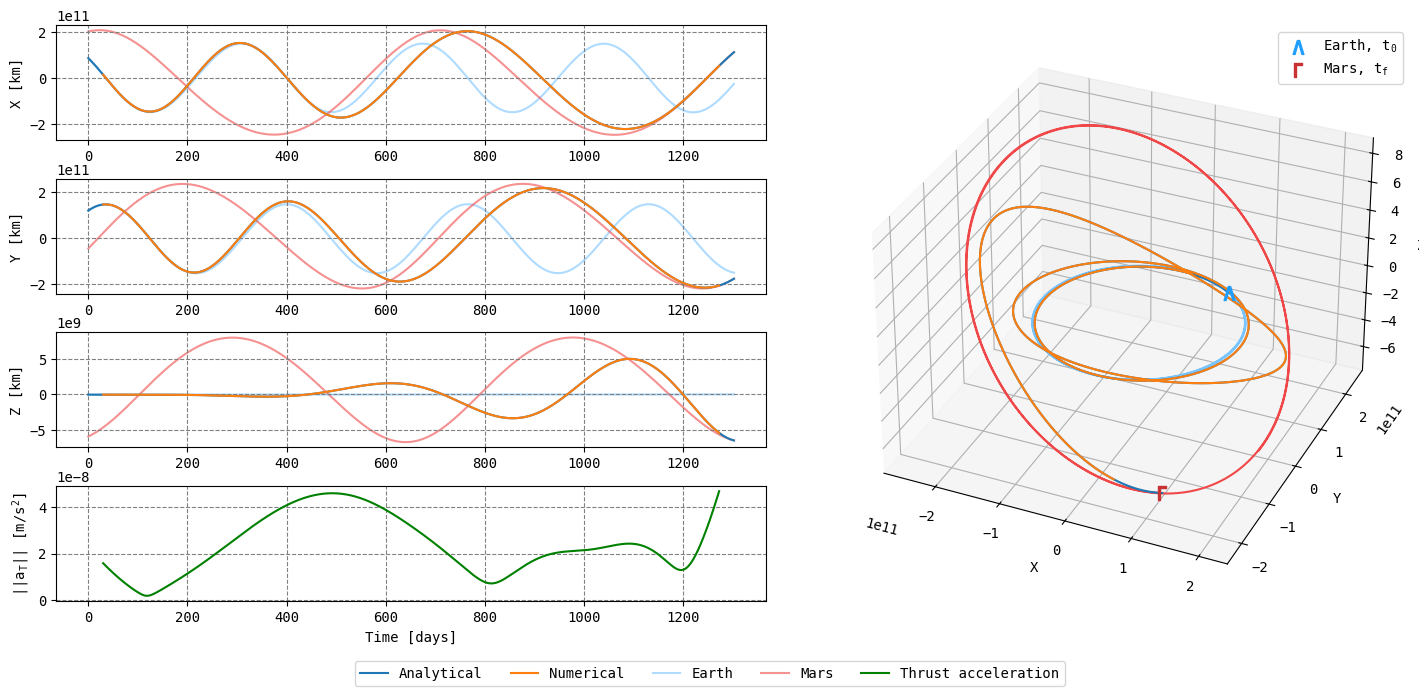

In [15]:
inspect_low_thrust_trajectory(
    DateTime(2016,11,16),
    DateTime(2020,6,11)
)

**High $\Delta V$ trajectory**

526.24 km/s


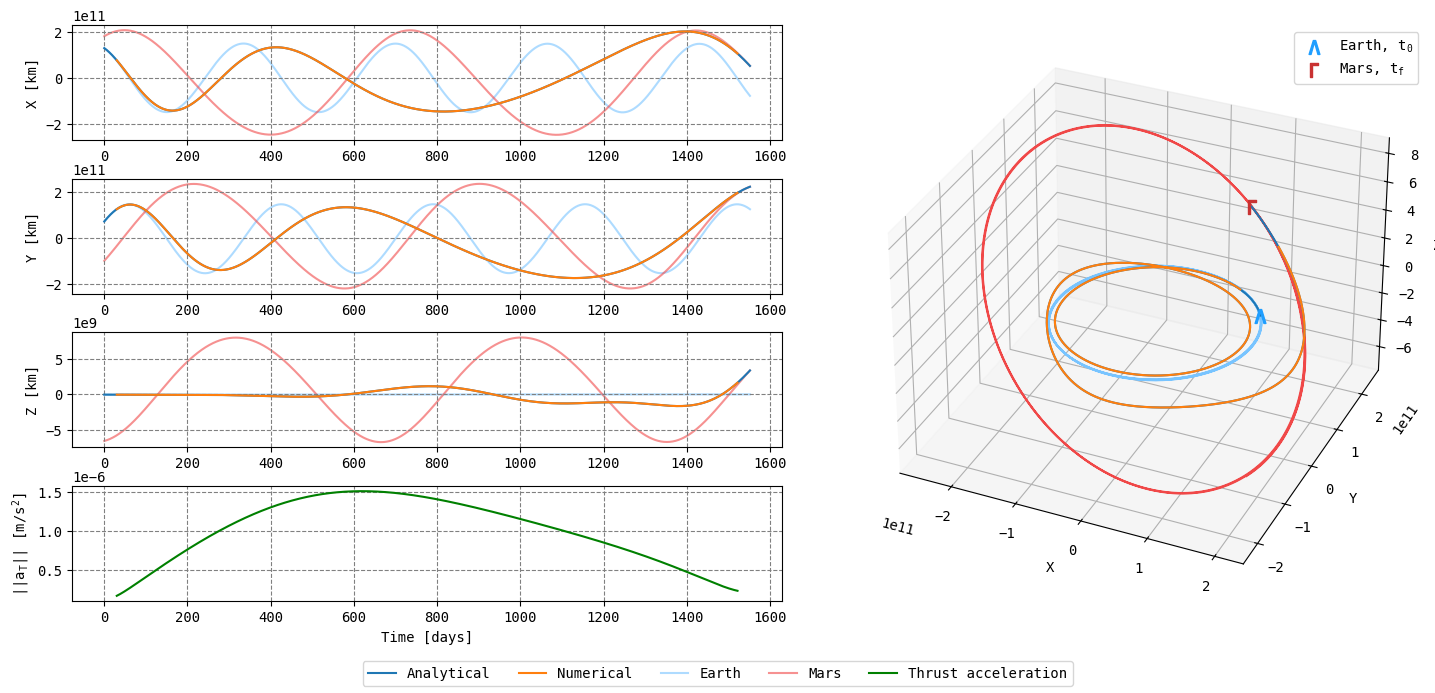

In [16]:
inspect_low_thrust_trajectory(
    DateTime(2016,10,22),
    DateTime(2021,1,21)
)